This project aims to create a classification model that classifies the categories of news articles from the BBC News archive.

In [42]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [43]:
with open("./BBC_News_Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

Each data point looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002.

In [44]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

##Preprocessing the data
This code removes the stopwords from text.

In [45]:
#args: sentence to remove stopwords from
def remove_stopwords(sentence):

  #defining stopwords
  stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

  #sentences converted to lowercase
  sentence = sentence.lower()

  words = sentence.split()
  no_words = [w for w in words if w not in stopwords]
  sentence = " ".join(no_words)

  return sentence

This code loads the data from a csv file and extracts sentences and labels.

In [46]:
#arfs: filename (string) - path to the csv file
def parse_data_from_file(filename):
  sentences = []
  labels = []
  with open(filename, 'r') as csvfile: #open as read mode
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader) #skips the header row
    for row in reader:
      labels.append(row[2])
      sentence = row[1]
      sentence = remove_stopwords(sentence)
      sentences.append(sentence)

  return sentences, labels

In [47]:
# Testing the functions
sentences, labels = parse_data_from_file("./BBC_News_Train.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


##Training - Validation split
This code splits the training set into training and validation sets

In [69]:
def train_val_split(sentences, labels, training_split):
  train_size = int(len(sentences) * training_split)

  train_sentences = sentences[0:train_size]
  train_labels = labels[0:train_size]

  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels

In [70]:
# Testing the function
train_sentences, train_labels, val_sentences, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


##Tokenization - Sequences and Padding
This code returns a Tokenizer that has been fitted to the training sentences.

In [71]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  """
  Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
  """

  #instantiating the Tokenizer class
  tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)

  #fitting the tokenizer to the training sentences
  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

This code converts each text data point into its padded sequence representation.

In [72]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):

  sequences = tokenizer.texts_to_sequences(sentences)
  padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = 'post')

  return padded_sequences

In [73]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


This code tokenizes the labels.

In [74]:
def tokenize_labels(all_labels, split_labels):
  """
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    Returns:
        label_seq_np (array of int): tokenized labels
  """

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(all_labels)
  label_seq = label_tokenizer.texts_to_sequences(split_labels)
  label_seq_padded = pad_sequences(label_seq, padding='post')

  # Converting sequences to a numpy array (for neural networks)
  # Subtracting 1 to ensure indices start from 0
  label_seq_np = np.array(label_seq_padded) -1

  return label_seq_np

In [75]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[3]
 [3]
 [2]
 [1]
 [4]]

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



##Creating the model
This code builds a model that classify each text as being part of a certain category.

In [76]:
def create_model(num_words, embedding_dim, maxlen):
  """
    Args:
          num_words (int): size of the vocabulary for the Embedding layer input
          embedding_dim (int): dimensionality of the Embedding layer output
          maxlen (int): length of the input sequences
  """

  #Ensuring reproducibility
  tf.random.set_seed(123)

  #Creating the model
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, output_dim = embedding_dim, input_length = maxlen),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(6, activation = 'relu'),
      tf.keras.layers.Dense(5, activation = 'softmax')
  ])

  #Compiling the model
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

In [77]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(
  train_padded_seq,
  train_label_seq,
  epochs=30,
  validation_data=(val_padded_seq, val_label_seq)
)

Epoch 1/30
38/38 [==============================] - 1s 9ms/step - loss: 1.6016 - accuracy: 0.2634 - val_loss: 1.5934 - val_accuracy: 0.3255
Epoch 2/30
38/38 [==============================] - 0s 3ms/step - loss: 1.5814 - accuracy: 0.4169 - val_loss: 1.5722 - val_accuracy: 0.3557
Epoch 3/30
38/38 [==============================] - 0s 4ms/step - loss: 1.5530 - accuracy: 0.3993 - val_loss: 1.5422 - val_accuracy: 0.3826
Epoch 4/30
38/38 [==============================] - 0s 3ms/step - loss: 1.5130 - accuracy: 0.4841 - val_loss: 1.5012 - val_accuracy: 0.4530
Epoch 5/30
38/38 [==============================] - 0s 3ms/step - loss: 1.4598 - accuracy: 0.5310 - val_loss: 1.4470 - val_accuracy: 0.5336
Epoch 6/30
38/38 [==============================] - 0s 4ms/step - loss: 1.3919 - accuracy: 0.5579 - val_loss: 1.3815 - val_accuracy: 0.5638
Epoch 7/30
38/38 [==============================] - 0s 4ms/step - loss: 1.3100 - accuracy: 0.6065 - val_loss: 1.3041 - val_accuracy: 0.5772
Epoch 8/30
38/38 [==

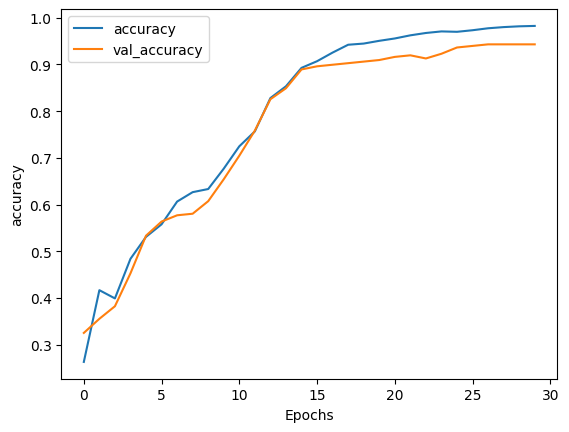

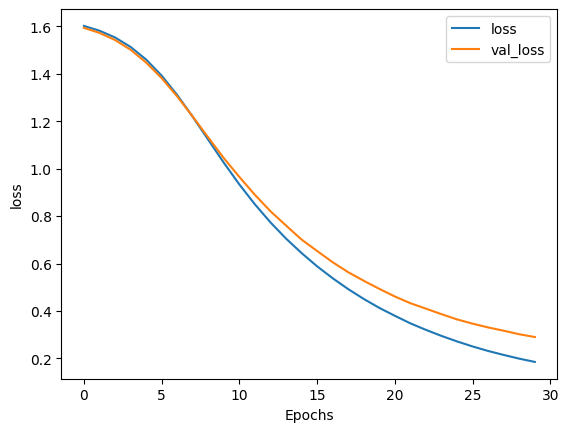

In [78]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

##Visualizing 3D Vectors

This will be used in [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [79]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


This code generates the `vecs.tsv` and `meta.tsv` files that will be uploaded to the embedding projector.

In [80]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()